<a href="https://colab.research.google.com/github/mannbajpai/ML-learning/blob/main/Generating_Digits_using_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name : Mann Bajpai
# Roll Number : 21CS2011
# Branch : IDD CSE
# Artificial Intelligence Project


# Generating Handwritten Digits *(0-9)* using **GANs**(Generative Adversial Network) with **MNIST** Dataset

### Goal
In this notebook, I will build and train a GAN that can generate hand-written images of digits (0-9), using PyTorch.

### Learning Objectives
1.   Build the generator and discriminator components of a GAN from scratch.
2.   Create generator and discriminator loss functions.
3.   Train your GAN and visualize the generated images.


## Getting Started

Importing useful libraries to create our GAN architecture


In [23]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### MNIST Dataset
For training our discriminator will be using is from a dataset called [MNIST](http://yann.lecun.com/exdb/mnist/). It contains 60,000 images of handwritten digits, from 0 to 9, like these:

![MNIST Digits](https://production-media.paperswithcode.com/datasets/MNIST-0000000001-2e09631a_09liOmx.jpg)



## Generator


In [24]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

## Generator Class

It will take 3 values:

*   The noise vector dimension
*   The image dimension
*   The initial hidden dimension

Using these values, the generator will build a neural network with 5 layers/blocks. Beginning with the noise vector, the generator will apply non-linear transformations via the block function until the tensor is mapped to the size of the image to be outputted (the same size as the real images from MNIST).





In [25]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)

    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

## Noise

To be able to use your generator, you will need to be able to create noise vectors. The noise vector z has the important role of making sure the images generated from the same class don't all look the same. You will generate it randomly using PyTorch by sampling random numbers from the normal distribution.



In [26]:

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device = device)

## Discriminator







In [27]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation
          followed by an nn.LeakyReLU activation with negative slope of 0.2
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)
    )

## Discriminator Class

The discriminator class has 2 parameters
*   The image dimension
*   The hidden dimension

The discriminator will build a neural network with 4 layers. It will start with the image tensor and transform it until it returns a single number (1-dimension tensor) output. This output classifies whether an image is fake or real. Note that you do not need a sigmoid after the output layer since it is included in the loss function. Finally, to use your discrimator's neural network you are given a forward pass function that takes in an image tensor to be classified.


In [28]:

class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)


    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

## Training
First, we will set our parameters:
  *   criterion: the loss function (BCE)
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type, here using a GPU (which runs CUDA), not CPU




In [29]:
# Setting the parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

device = 'cuda'

Lets initialize our generator, discriminator, and optimizers.

In [30]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Before you train your GAN, you will need to create functions to calculate the discriminator's loss and the generator's loss. This is how the discriminator and generator will know how they are doing and improve themselves.

In [31]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare
               the discriminator's predictions to the ground truth reality of the images
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce,
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    fake_images = gen(get_noise(num_images, z_dim, device=device))
    fake_images.detach_()
    fake_loss = criterion(disc(fake_images),torch.zeros((num_images,1),device = device))
    real_loss = criterion(disc(real),torch.ones((num_images,1),device = device))
    disc_loss = ( fake_loss + real_loss ) / 2.0

    return disc_loss

## Generator Loss

In [32]:

def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare
               the discriminator's predictions to the ground truth reality of the images
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce,
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''

    noises = get_noise(num_images,z_dim, device = device)
    fake_images = gen(noises)
    out = disc(fake_images)
    gen_loss = criterion(out, torch.ones(num_images, 1).to(device))

    return gen_loss

Finally, we can put everything together! For each epoch, we will process the entire dataset in batches. For every batch, we will need to update the discriminator and generator using their loss. Batches are sets of images that will be predicted on before the loss functions are calculated (instead of calculating the loss function after each image).




Expected Output
![MNIST Digits](https://drive.google.com/uc?export=view&id=1BlfFNZACaieFrOjMv_o2kGqwAR6eiLmN)

Step 37000: Generator loss: 2.3007227554321297, discriminator loss: 0.263817606508732


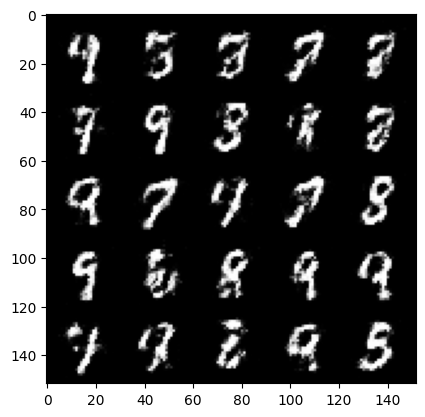

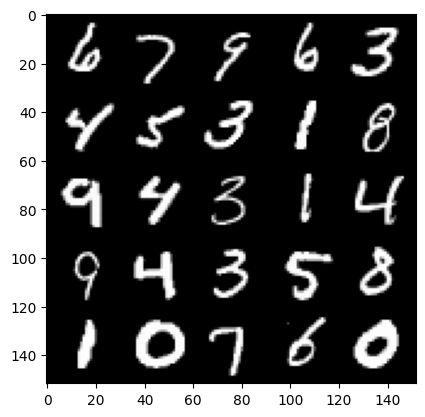

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True
gen_loss = False
error = False
for epoch in range(n_epochs):

    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        # 1) Zero out the gradients.
        # 2) Calculate the generator loss, assigning it to gen_loss.
        # 3) Backprop through the generator: update the gradients and optimizer.

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()


        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


## Conclusion

* ### The project is ready and we have Generated handwritten digits (0-9) by using a GAN. Because of the limits of my system hardware and resources I cannot train it to generate very accurate images of the digits.
* ### With a help of a powerful **NVIDIA Cuda powered GPU** and increasing the number of epochs to 200 and batch size to about 128 we can generate images similar to the dataset
